# Takehome Challenge<br>
Relax Inc.<br>
Taylor Willingham<br>
September 2019<br>

<b>The Challenge</b><br>
Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven-day
period, identify which factors predict future user adoption. We suggest spending 1-2 hours on this, but you're welcome to spend more or less.<br>
<br>
Please send us a brief writeup of your findings (the more concise, the better no more than one page), along with any summary tables, graphs, code, or queries that can help us understand your approach. Please note any factors you considered or investigation you did, even if they did not pan out. Feel free to identify any further research or data
you think would be valuable.

<b>Writeup</b><br>
This is a brief summary of my findings. All code and visuals can be found below.<br>
<br>
After determining which users qualified as "adopted", I did a few basic comparisons on some of the features between adopters and non-adopters. Because this is a binary classification problem and basically all the relevant features are discrete, the comparisons mainly consisted of count-plots for different variables. From the visuals, there wasn't much insight. The distributions of `creation_source`, meaning how the user joined, were different for each group, but there wasn't a clear takeaway. On the other hand, the distributions of users who joined the mailing list was virtually identical for both groups, which is unhelpful due to the similarity. I also thought about comparing the organization IDs to see if users from a particular organization might be more active, but there were too many unique values.<br>
<br>
Next, I put together a couple of machine learning models to see if those could help solve the problem. I tried logistic regression and random forest, both of which scored well in terms of accuracy. As for important features, logistic regression seemed most impacted by the mode of signup, or `creation_source`, while random forest strongly emphasized the last login date for each user. It would be nice if both models preferred the same features, but each makes sense in its own right. Users who signup themselves might be more active than those who are invited, and most recent login could be correlated to overall activity.<br>
<br>
I think a good next step would be to dive further into the user activity table to see just how active "adopted" users are. I also think some demographic information, which was completely lacking from the data, would be very useful. Things like gender and age are important to consider with software users, and could prove helpful in this situation.

<b>Setting up the workspace</b>

In [1]:
import pandas as pd
from pandas import datetime
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline
sns.set_style('darkgrid')

In [2]:
users = pd.read_csv('takehome_users.csv', encoding='latin_1')

In [3]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [12]:
engagement = pd.read_csv('takehome_user_engagement.csv')

# Add column to check if user has adopted
engagement['three_in_seven'] = 0

# trim time stamp to only include the date; time is not needed
engagement['time_stamp'] = engagement['time_stamp'].str.slice(0,10)

# convert to datetime
engagement['time_stamp'] = engagement['time_stamp'].astype('datetime64[D]')

In [13]:
engagement.head(8)

,time_stamp,user_id,visited,three_in_seven
0,2014-04-22,1,1,0
1,2013-11-15,2,1,0
2,2013-11-29,2,1,0
3,2013-12-09,2,1,0
4,2013-12-25,2,1,0
5,2013-12-31,2,1,0
6,2014-01-08,2,1,0
7,2014-02-03,2,1,0


It appears the `engagement` table is sorted by `user_id` and then by `time_stamp`, so we need to find a way to check each user id to determine if there are any seven-day periods with at least three logins.<br>
<br>
Here I iterate through the engagement dataframe by user id and search each subset for a third visit occurring in seven days or less, making sure each time stamp represents a unique date. Each subset is then compiled into the `eng_compiled` dataframe.

In [14]:
eng_compiled = pd.DataFrame(columns=['time_stamp', 'user_id', 'visited', 'three_in_seven', 'shift'])

In [15]:
from datetime import timedelta

ids = list(set(engagement.user_id))

for i in ids:
    subset = engagement[engagement.user_id == i]
    subset = subset.drop_duplicates(subset='time_stamp')
    subset['shift'] = subset['time_stamp'].shift(2)
    subset['three_in_seven'] = subset['time_stamp'] < (subset['shift'] + timedelta(days=7))
    eng_compiled = eng_compiled.append(subset, ignore_index=True)

In [16]:
eng_compiled = eng_compiled.drop('visited', axis=1)
eng_compiled.head(12)

,time_stamp,user_id,three_in_seven,shift
0,2014-04-22,1,False,NaT
1,2013-11-15,2,False,NaT
2,2013-11-29,2,False,NaT
3,2013-12-09,2,False,2013-11-15
4,2013-12-25,2,False,2013-11-29
5,2013-12-31,2,False,2013-12-09
6,2014-01-08,2,False,2013-12-25
7,2014-02-03,2,False,2013-12-31
8,2014-02-08,2,False,2014-01-08
9,2014-02-09,2,True,2014-02-03


We can see above that indices 9 and 10 correctly have a `True` value because those logins occurred within seven days of the two before.<br>
<br>
The next step is to find the unique user ids that contain a `True` value and merge those with the `users` table. That will essentially create our target variable.

In [17]:
trues = eng_compiled[eng_compiled.three_in_seven == True]

In [22]:
unique_trues = trues.drop_duplicates(subset='user_id')

# we really only need the id number
unique_trues = unique_trues[['user_id']].reset_index(drop=True)
unique_trues.head()

,user_id
0,2
1,10
2,20
3,33
4,42


In [24]:
unique_trues.shape

(1602, 1)

In [26]:
merged = pd.merge(users, unique_trues, left_on='object_id', right_on='user_id', how='left')
merged.head(5)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,NaN
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,NaN
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,NaN
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,NaN


In [27]:
# Creating the target variable
merged['adopted'] = 0
merged.loc[merged.user_id > 0, 'adopted'] = 1        

In [59]:
adopted = merged.drop('user_id', axis=1)
adopted.head(12)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,1.387424e+09,0,0,197,11241.0,0
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,1.356010e+09,0,1,37,NaN,0
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaN,1,1,74,NaN,0
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,302,NaN,0
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143.0,1


Great, there is now a dataframe to identify all "adopted" users. Before moving on with analysis, we can remove the name and email columns, as those will just get in the way.

In [60]:
adopted = adopted.drop(['name', 'email'], axis=1)

In [61]:
adopted.head()

,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


<b>Basic Comparisons</b><br>
Let's compare the two classes.

In [62]:
percent_adopt = (len(adopted[adopted.adopted == 1]) / len(adopted)) * 100
print('Percentage of adopted users is {:.2f}%'. format(percent_adopt))

Percentage of adopted users is 13.35%


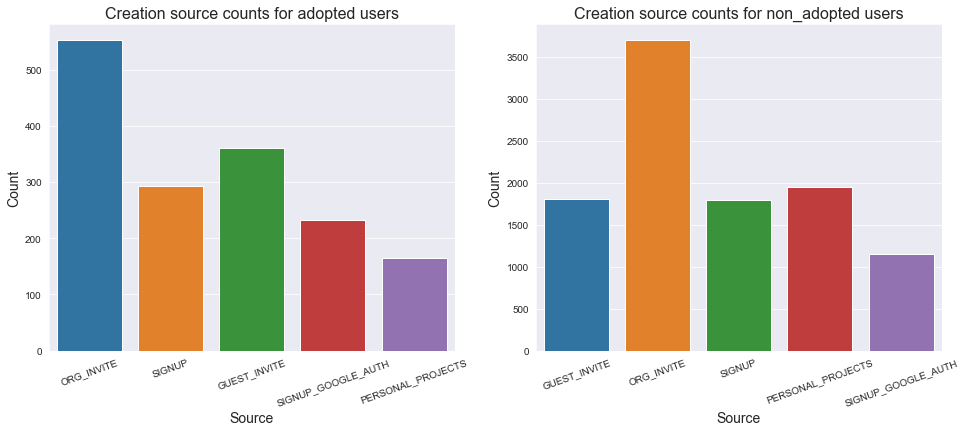

In [45]:
fig = plt.figure(figsize=(16,6))

ax1 = plt.subplot(1,2,1)
_ = sns.countplot(x='creation_source', data=adopted[adopted.adopted==1])
_ = plt.xlabel('Source', fontsize=14)
_ = plt.ylabel('Count', fontsize=14)
_ = plt.title('Creation source counts for adopted users', fontsize=16)
_ = plt.xticks(rotation=20)

ax1 = plt.subplot(1,2,2)
_ = sns.countplot(x='creation_source', data=adopted[adopted.adopted==0])
_ = plt.xlabel('Source', fontsize=14)
_ = plt.ylabel('Count', fontsize=14)
_ = plt.title('Creation source counts for non_adopted users', fontsize=16)
_ = plt.xticks(rotation=20)

The label ordering of the two plots is a little confusing, but it looks as though signups and guest invites play a slightly stronger role for those users who adopted.

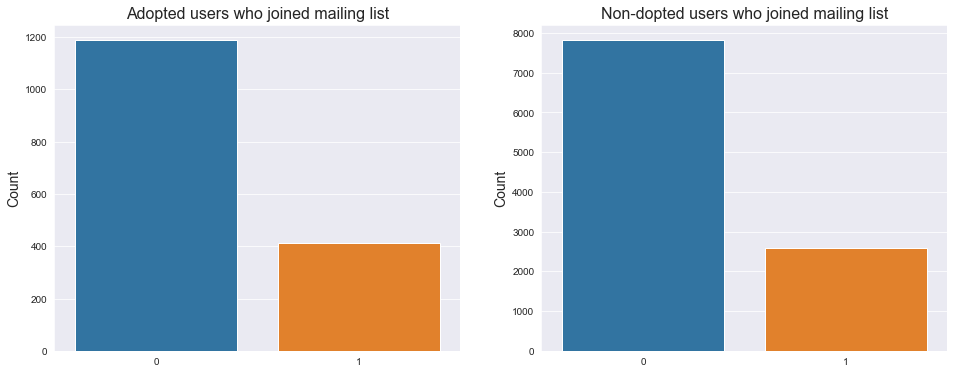

In [50]:
fig = plt.figure(figsize=(16,6))

ax1 = plt.subplot(1,2,1)
_ = sns.countplot(x='opted_in_to_mailing_list', data=adopted[adopted.adopted==1])
_ = plt.xlabel('', fontsize=14)
_ = plt.ylabel('Count', fontsize=14)
_ = plt.title('Adopted users who joined mailing list', fontsize=16)

ax1 = plt.subplot(1,2,2)
_ = sns.countplot(x='opted_in_to_mailing_list', data=adopted[adopted.adopted==0])
_ = plt.xlabel('', fontsize=14)
_ = plt.ylabel('Count', fontsize=14)
_ = plt.title('Non-dopted users who joined mailing list', fontsize=16)

As for percentage of users that opted in to the mailing list, these plots are essentially identical meaning it doesn't offer much information when it comes to determining whether a user adopted or not.

<b>Setting up a model</b>

The `adopted` table needs to be set up for machine learning, creating dummy labels for any discrete variables and handling null values.

In [63]:
adopted.isna().any()

object_id                     False
creation_time                 False
creation_source               False
last_session_creation_time     True
opted_in_to_mailing_list      False
enabled_for_marketing_drip    False
org_id                        False
invited_by_user_id             True
adopted                       False
dtype: bool

In [88]:
alt_adopt = adopted.drop(['object_id', 'org_id'], axis=1)

In [89]:
# Breakdown creation time by year to make it a simple discrete variable

alt_adopt['creation_time'] = pd.to_datetime(alt_adopt['creation_time'])

alt_adopt['creation_time'] = alt_adopt['creation_time'].dt.year

alt_adopt['creation_time'] = alt_adopt['creation_time'].astype('object')
        
alt_adopt.head(2)

,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,invited_by_user_id,adopted
0,2014,GUEST_INVITE,1.398139e+09,1,0,10803.0,0
1,2013,ORG_INVITE,1.396238e+09,0,0,316.0,1


In [90]:
# update 'invited' column to binary to remove NaN values
# also will cut down number of dummy variables needed

for i, row in alt_adopt.iterrows():
    if alt_adopt.loc[i, 'invited_by_user_id'] > 0:
        alt_adopt.loc[i, 'invited_by_user_id'] = 1
    else:
        alt_adopt.loc[i, 'invited_by_user_id'] = 0
        
alt_adopt.iloc[5:7]

,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,invited_by_user_id,adopted
5,2013,GUEST_INVITE,1.387424e+09,0,0,1.0,0
6,2012,SIGNUP,1.356010e+09,0,1,0.0,0


In [91]:
# for 'session_time' NaN values will just be changed to zero.
# This column can be treated as a continuous variable

alt_adopt = alt_adopt.fillna(0)

In [92]:
alt_adopt.isna().any()

creation_time                 False
creation_source               False
last_session_creation_time    False
opted_in_to_mailing_list      False
enabled_for_marketing_drip    False
invited_by_user_id            False
adopted                       False
dtype: bool

In [93]:
alt_adopt = pd.get_dummies(alt_adopt, columns=['creation_source', 'creation_time'], drop_first=True)

Now that the data set has been adjusted, we can create our X and y variables and proceed.

In [94]:
from sklearn.model_selection import train_test_split

X = alt_adopt.loc[:, alt_adopt.columns != 'adopted']
y = alt_adopt.adopted

state = 4

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.28, stratify=y, random_state=state)

In [101]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

log_r = LogisticRegression(solver='lbfgs')

params = {'C': [0.0000001, 0.001, 0.01, 0.1]}

log_grid = GridSearchCV(log_r, params, cv=6)

log_grid.fit(X_train, y_train)

print('Best C: ', log_grid.best_estimator_)
print('Best score: ', log_grid.best_score_)

Best C:  LogisticRegression(C=1e-07, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Best score:  0.8665354786433614


In [106]:
from sklearn.metrics import accuracy_score

log_val = LogisticRegression(solver='lbfgs', C=0.0000001)

log_val.fit(X_train, y_train)

pred = log_val.predict(X_test)

print(accuracy_score(y_test, pred))

0.8664088069027075


The accuracy is higher than I expected, and the model seems to generalize well on unseen data. The data is unbalanced, but we stratified the test set to try and account for that.<br>
<br>
Let's see which variables had the most impact. All the coefficients are negative, but we are interested in the positive class so we want the coefficients that are least negative.

In [121]:
log_val.coef_

array([[-1.07972864e-09, -1.30001477e-18, -7.31102045e-19,
        -2.69209582e-18, -1.91407180e-18, -1.96666249e-18,
        -6.52620226e-19, -1.28823506e-19, -2.30891029e-18,
        -2.08233605e-18]])

In [122]:
coefs = log_val.coef_[0]
top_coefs = np.argpartition(coefs, -5)[-5:]
top_sorted = top_coefs[np.argsort(coefs[top_coefs])]
print(X_test.columns[top_sorted])

Index(['creation_source_ORG_INVITE', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'creation_source_SIGNUP',
       'creation_source_SIGNUP_GOOGLE_AUTH'],
      dtype='object')


We can also try a decistion tree based model to get feature importances.

In [123]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100,\
                            oob_score=True,\
                            random_state=4,\
                            n_jobs=-1)

rf.fit(X_train, y_train)
print(rf.oob_score_)

0.9307790253501562


In [124]:
rf_pred = rf.predict(X_test)
accuracy_score(y_test, rf_pred)

0.9345432906872955

Again, the results are good, and the model doesn't seem to overfit.

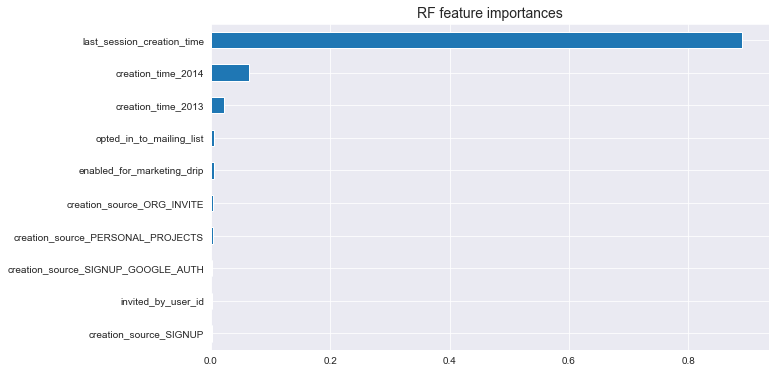

In [125]:
important = pd.Series(data=rf.feature_importances_, index=X_train.columns).sort_values()

fig = plt.subplots(figsize=(10,6))
_ = important.plot(kind='barh')
_ = plt.title('RF feature importances', fontsize=14)

Whereas logistic regression tended to favor the method of signup, random forest clearly values the most recent activity. This seems to indicate that activity matters.